# **Twain Topic Model and Word Embeddings**

## **DS 5001: Exploratory Text Analytics**

## **Cecily Wolfe (cew4pf)**

## **Spring 2022**

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
from topicmodel import TopicModel

In [3]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [4]:
BOW = pd.read_csv("twain_BOW.csv")
BOW['term_str'] = BOW['term_str'].astype('str')
BOW = BOW.set_index(['book_id', 'chap_id', 'term_str'])

In [5]:
LIB = pd.read_csv(("twain_pre_LIB.csv"), index_col = ['book_id'])

In [6]:
CORPUS = pd.read_csv(("twain_pre_CORPUS.csv"), index_col = OHCO)

In [7]:
VOCAB = pd.read_csv("twain_pre_VOCAB.csv")

VOCAB['term_str'] = VOCAB['term_str'].astype('str')

VOCAB = VOCAB.set_index('term_str')

VOCAB['pos_group'] = VOCAB.max_pos.str.slice(0,2)

In [8]:
CHAPS = CORPUS.groupby(OHCO[:2]+['term_str']).term_str.count().unstack()
VOCAB['df'] = CHAPS.count()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(CHAPS)/VOCAB.df)

In [9]:
VOCAB.head()

n  n_chars         p          i max_pos  n_pos  \
term_str                                                   
0         5        1  0.000002  19.180285      CD      1   
00        3        2  0.000001  19.917251      NN      2   
01        3        2  0.000001  19.917251     NNS      2   
02        4        2  0.000001  19.502213      NN      3   
03        6        2  0.000002  18.917251      NN      3   

                       cat_pos  stop stem_porter stem_snowball stem_lancaster  \
term_str                                                                        
0                       {'CD'}     0           0             0              0   
00               {'NN', 'NNS'}     0          00            00             00   
01               {'NN', 'NNS'}     0          01            01             01   
02        {'POS', 'NN', 'NNP'}     0          02            02             02   
03        {'POS', 'NN', 'NNS'}     0          03            03             03   

         pos_group   df      dfidf  
term_str                            
0               CD  2.0  18.227484  
00              NN  1.0  10.113742  
01              NN  1.0  10.113742  
02              NN  2.0  18.227484  
03              NN  1.0  10.113742

In [10]:
BOW.head()

n        tf     tfidf
book_id chap_id term_str                       
70      1       1835      1  0.142857  1.159106
                1910      1  0.142857  1.075540
                a         2  0.285714  0.002238
                alphabet  1  0.142857  0.991974
                as        2  0.285714  0.013615

In [11]:
LIB.head()

source_file_path  \
book_id                                                      
70                                Twain/70-what_is_man.txt   
74               Twain/74-the_adventures_of_tom_sawyer.txt   
76         Twain/76-the_adventures_of_huckleberry_finn.txt   
86       Twain/86-a_connecticut_yankee_in_king_arthurs_...   
91                          Twain/91-tom_sawyer_abroad.txt   

                                              title  \
book_id                                               
70                                      what is man   
74                     the adventures of tom sawyer   
76               the adventures of huckleberry finn   
86       a connecticut yankee in king arthurs court   
91                                tom sawyer abroad   

                                                chap_regex author  \
book_id                                                             
70       WHAT IS MAN?|THE DEATH OF JEAN|THE TURNING-POI...  twain   
74                                ^\s*CHAPTER\s*[IVXLCM]+$  twain   
76                 ^\s*CHAPTER\s*(?:[IVXLCM]+\.|THE LAST)$  twain   
86       ^\s*(?:PREFACE|A WORD OF EXPLANATION|THE STRAN...  twain   
91                                    CHAPTER\s[IVXLCM]+\.  twain   

                type  year  decade  n_chaps  book_len  
book_id                                                
70       non-fiction  1906    1900       17     96111  
74             novel  1876    1870       35     70276  
76             novel  1884    1880       43    111908  
86             novel  1889    1880       47    119100  
91             novel  1894    1890       13     33969

## **M08: Topic Models**

In [12]:
# join BOW and VOCAB
joint_BOW = BOW.reset_index().set_index('term_str').join(VOCAB, rsuffix = "_vocab")

# remove nan
joint_BOW = joint_BOW.loc[~joint_BOW.isna().any(axis = 1)]

# remove proper nouns
joint_BOW = joint_BOW.loc[~joint_BOW.max_pos.isin(['NNP', 'NNPS'])]

joint_BOW

book_id  chap_id  n        tf     tfidf  n_vocab  n_chars  \
term_str                                                                    
0                  3199        1  2  0.008439  0.076909        5        1   
0                  3251        6  3  0.004587  0.041806        5        1   
00                 3199       24  3  0.012448  0.125897        3        2   
01                 3199       25  3  0.013699  0.138544        3        2   
02                 3186       14  1  0.005464  0.049802        4        2   
...                 ...      ... ..       ...       ...      ...      ...   
étouffante        60900        5  1  0.007752  0.078401        1       10   
évitant            3189        3  1  0.004132  0.041792        1        7   
êtes               3189        3  1  0.004132  0.041792        1        4   
öffnen            60900        6  1  0.004608  0.046607        1        6   
übergeschlagen    60900        6  1  0.004608  0.046607        1       14   

                           p          i max_pos  n_pos               cat_pos  \
term_str                                                                       
0               1.683290e-06  19.180285      CD      1                {'CD'}   
0               1.683290e-06  19.180285      CD      1                {'CD'}   
00              1.009974e-06  19.917251      NN      2         {'NN', 'NNS'}   
01              1.009974e-06  19.917251     NNS      2         {'NN', 'NNS'}   
02              1.346632e-06  19.502213      NN      3  {'POS', 'NN', 'NNP'}   
...                      ...        ...     ...    ...                   ...   
étouffante      3.366579e-07  21.502213      NN      1                {'NN'}   
évitant         3.366579e-07  21.502213     VBP      1               {'VBP'}   
êtes            3.366579e-07  21.502213     NNS      1               {'NNS'}   
öffnen          3.366579e-07  21.502213      NN      1                {'NN'}   
übergeschlagen  3.366579e-07  21.502213      NN      1                {'NN'}   

                stop     stem_porter   stem_snowball stem_lancaster pos_group  \
term_str                                                                        
0                  0               0               0              0        CD   
0                  0               0               0              0        CD   
00                 0              00              00             00        NN   
01                 0              01              01             01        NN   
02                 0              02              02             02        NN   
...              ...             ...             ...            ...       ...   
étouffante         0       étouffant       étouffant         étouff        NN   
évitant            0         évitant         évitant           évit        VB   
êtes               0             ête            êtes            ête        NN   
öffnen             0          öffnen          öffnen         öffnen        NN   
übergeschlagen     0  übergeschlagen  übergeschlagen     übergeschl        NN   

                 df      dfidf  
term_str                        
0               2.0  18.227484  
0               2.0  18.227484  
00              1.0  10.113742  
01              1.0  10.113742  
02              2.0  18.227484  
...             ...        ...  
étouffante      1.0  10.113742  
évitant         1.0  10.113742  
êtes            1.0  10.113742  
öffnen          1.0  10.113742  
übergeschlagen  1.0  10.113742  

[877057 rows x 19 columns]

In [13]:
# recover filtered BOW --> drop cols added by VOCAB and reset index to book_id, chap_id, term_str

filtered_BOW = joint_BOW.drop(joint_BOW.loc[:, 'n_vocab':].columns, axis = 1).reset_index().set_index(['book_id', 'chap_id', 'term_str'])

# sort by book id
filtered_BOW = filtered_BOW.sort_values('book_id')

filtered_BOW

n        tf     tfidf
book_id chap_id term_str                         
70      10      read        3  0.014423  0.019551
                stock       1  0.004808  0.013125
        16      stock       1  0.010989  0.030000
        17      stock       2  0.001498  0.004090
        2       inert       1  0.000732  0.005080
...                        ..       ...       ...
62739   4       two         5  0.017668  0.003841
        5       two         4  0.038095  0.008282
        4       most        3  0.010601  0.004905
        2       everything  2  0.005556  0.006925
                officials   1  0.002778  0.012337

[877057 rows x 3 columns]

In [14]:
# removed ~ 5% of data when taking out proper nouns (singular and plural)
(BOW.shape[0] - filtered_BOW.shape[0]) / BOW.shape[0]

0.05007110465109982

In [15]:
n_topics = 40
n_terms = 2000

In [16]:
tm = TopicModel(filtered_BOW)
tm.n_topics = n_topics
tm.n_terms = n_terms

In [17]:
tm.create_X()
tm.get_model()
tm.describe_topics()
tm.get_model_stats()

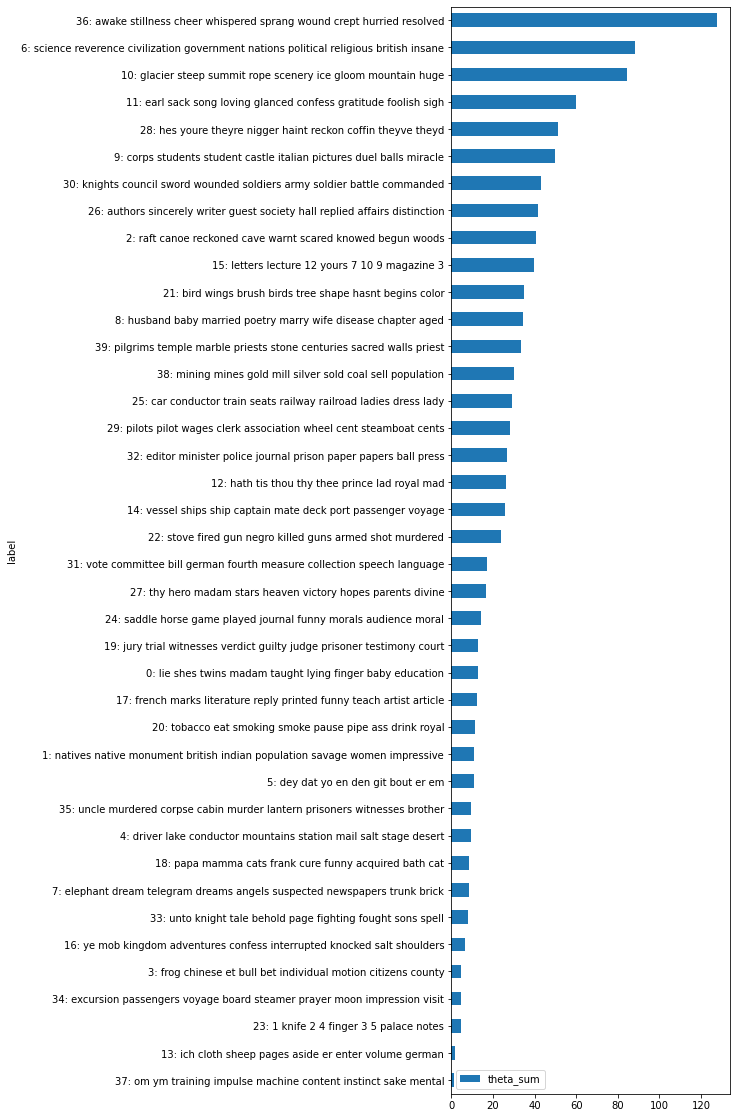

In [18]:
tm.plot_topics()

In [19]:
# table with distribution of topics for each doc
tm.THETA

topic_id               0         1         2         3         4         5   \
book_id chap_id                                                               
70      1        0.002273  0.002273  0.002273  0.002273  0.002273  0.002273   
        2        0.000005  0.000005  0.000005  0.000005  0.000005  0.000005   
        3        0.000036  0.000036  0.000036  0.000036  0.010489  0.000036   
        4        0.000038  0.000038  0.000038  0.000038  0.000038  0.000038   
        5        0.000028  0.000028  0.000028  0.000028  0.000028  0.000028   
...                   ...       ...       ...       ...       ...       ...   
62739   2        0.000023  0.073183  0.036687  0.000023  0.005265  0.000023   
        3        0.000227  0.000227  0.000227  0.000227  0.000227  0.000227   
        4        0.000054  0.050824  0.000054  0.000054  0.025275  0.000054   
        5        0.000144  0.000144  0.000144  0.000144  0.000144  0.000144   
        6        0.000581  0.000581  0.000581  0.000581  0.000581  0.000581   

topic_id               6         7         8         9   ...        30  \
book_id chap_id                                          ...             
70      1        0.678106  0.002273  0.002273  0.002273  ...  0.002273   
        2        0.000005  0.000005  0.000005  0.000005  ...  0.000005   
        3        0.000036  0.000036  0.009727  0.088655  ...  0.112232   
        4        0.435486  0.000038  0.000038  0.000038  ...  0.043335   
        5        0.105762  0.000028  0.000028  0.314828  ...  0.019001   
...                   ...       ...       ...       ...  ...       ...   
62739   2        0.379604  0.000023  0.059696  0.000023  ...  0.109367   
        3        0.411287  0.000227  0.165402  0.000227  ...  0.000227   
        4        0.653492  0.000054  0.000054  0.037204  ...  0.000054   
        5        0.692254  0.000144  0.000144  0.000144  ...  0.000144   
        6        0.513626  0.000581  0.000581  0.000581  ...  0.000581   

topic_id               31        32        33        34        35        36  \
book_id chap_id                                                               
70      1        0.002273  0.002273  0.002273  0.002273  0.002273  0.002273   
        2        0.000005  0.000005  0.000005  0.000005  0.000005  0.000005   
        3        0.000036  0.000036  0.000036  0.000036  0.000036  0.000036   
        4        0.000038  0.000038  0.000038  0.000038  0.000038  0.107206   
        5        0.000028  0.174355  0.000028  0.000028  0.000028  0.015326   
...                   ...       ...       ...       ...       ...       ...   
62739   2        0.000023  0.000023  0.000023  0.000023  0.000023  0.102332   
        3        0.000227  0.000227  0.000227  0.000227  0.000227  0.000227   
        4        0.000054  0.000054  0.000054  0.000054  0.037396  0.000054   
        5        0.000144  0.000144  0.000144  0.000144  0.000144  0.000144   
        6        0.000581  0.068624  0.000581  0.000581  0.000581  0.000581   

topic_id               37        38        39  
book_id chap_id                                
70      1        0.002273  0.002273  0.002273  
        2        0.999816  0.000005  0.000005  
        3        0.000036  0.000036  0.057427  
        4        0.000038  0.021042  0.000038  
        5        0.000028  0.000028  0.000028  
...                   ...       ...       ...  
62739   2        0.000023  0.030935  0.027682  
        3        0.000227  0.000227  0.000227  
        4        0.000054  0.000054  0.000054  
        5        0.000144  0.000144  0.000144  
        6        0.000581  0.000581  0.000581  

[1108 rows x 40 columns]

In [20]:
# distrubution of words over topics
tm.PHI

term_str      german     ancient    allowed         art        thou  \
topic_id                                                              
0           8.025308    0.025000   0.025000    7.762330    0.025000   
1           0.025000    0.025000   0.025000    0.025000    0.025000   
2           0.025000    0.025000  27.847490    0.025000    0.025000   
3           0.025000    0.025000   0.025000    3.552965    0.025000   
4           0.025000    0.025000   3.561333    0.859023    0.025000   
5           0.025000    0.025000   0.025000    0.025000    0.025000   
6           1.606724   58.063440  78.634398   65.521863    0.025000   
7           0.025000    1.403531   0.025000    0.025000    0.025000   
8           0.025000   15.812970   3.202335    5.097929    3.700189   
9         142.250248   52.863735  40.318434  109.878943    0.025000   
10         14.314383   23.783597   0.025000    0.025000    0.025000   
11          0.025000    6.575866  13.534899   11.425903    2.618971   
12          0.025000   26.779278   0.025000   57.983577  325.409821   
13         39.439127    0.025000   0.025000    1.055050    1.027437   
14          0.025000    0.489465   4.510259    9.014678    0.025000   
15         23.423745    3.189324  25.701895    3.291962    0.025000   
16          0.025000    0.025000   0.037356    0.025000    0.025000   
17          0.025000    5.672838  13.243987   57.442185    0.025000   
18         10.479892    7.029229   8.349322    0.025000    0.025000   
19          0.025000    0.025000   3.775352    0.025000    0.025000   
20          4.107050    0.025000   0.025000    0.025000    0.025000   
21          0.025000    0.540559   0.025000   13.926766    0.025000   
22         10.543879    4.634565   1.686472    1.183793    0.025000   
23          0.025000    1.297191   0.025000    0.025000    0.025000   
24         11.474755    4.285487   0.025000    0.025000    0.025000   
25          6.360447    0.025000   1.401918    0.025000    0.025000   
26          0.025000    6.716472  19.627906    7.721242    0.025000   
27          0.025000    8.012943  13.513383   41.480125   65.362325   
28          0.025000    0.025000  47.382806    0.025000    0.025000   
29          0.025000    8.749385  21.605058    0.025000    0.025000   
30          0.025000    0.887764  12.717148    0.025000    0.025000   
31        132.133853    0.025000   0.025000    0.025000    0.025000   
32          0.025000    0.025000   0.025000    0.025000    0.025000   
33          0.025000    0.025000   0.025000    7.498789    0.025000   
34          0.025000   10.432333   0.025000    2.889008    0.025000   
35          0.025000    0.025000   0.025000    0.025000    0.025000   
36          0.025000    4.499162  61.774934    0.025000    0.025000   
37          0.025000    1.025000   0.025000    0.025000    0.025000   
38          3.165588    4.399512   0.025000    0.025000    0.025000   
39          0.025000  150.456353   4.098316    2.888871   12.031257   

term_str    private       month        mile       om    curious  ...  \
topic_id                                                         ...   
0          0.025000    0.025000    0.025000    0.025   0.025000  ...   
1          0.025000    0.025000    0.025000    0.025   0.025000  ...   
2          0.025000    0.025000  139.687435    0.025  11.561690  ...   
3          0.025000    0.025000    0.025000    0.025   0.025000  ...   
4          0.025000    0.725470    0.025000    0.025   4.394222  ...   
5          0.025000    7.134957    5.021558    0.025   0.025000  ...   
6         60.510445   25.791504   15.281461    0.025  83.738623  ...   
7          2.251557    0.025000    0.025000    0.025   0.025000  ...   
8         12.573707   37.355050    0.025000    0.025  12.738382  ...   
9         41.759558   28.939902    0.025000    0.025  35.785724  ...   
10         0.025000    5.974309  162.025042    0.025  23.526947  ...   
11        42.418284   10.252781    0.025000    0.025  13.772151  ...   
12       

In [21]:
tm.TOPIC.sort_values('theta_sum', ascending = False)

phi_sum   theta_sum      h  \
topic_id                                    
36        56674.817260  127.577716  10.13   
6         44859.419532   88.110400   9.92   
10        40207.637360   84.184373   9.90   
11        30476.677087   59.764951   9.89   
28        19540.766202   51.483016   9.05   
9         23108.804196   49.600283   9.86   
30        16947.303924   43.172027   9.28   
26        19734.061371   41.714986   9.67   
2         16895.707949   40.930780   9.07   
15        30783.182917   39.717141   9.62   
21        15361.746982   34.968000   9.23   
8         13636.500040   34.248539   9.43   
39        16583.089258   33.596436   9.14   
38        12089.462258   30.269851   9.18   
25        11914.347299   29.169184   9.12   
29        11689.267902   28.193424   9.07   
32        11099.074186   26.910419   9.24   
12        11305.222550   26.289940   9.13   
14        12234.126069   25.794035   8.62   
22        11200.302142   24.080291   9.41   
31         6793.966237   17.230533   8.87   
27        13266.099095   16.544906   9.58   
24         4336.777031   14.208223   8.56   
19         5515.768416   12.868162   7.65   
0          4497.493923   12.664865   8.79   
17         4065.521650   12.361717   8.34   
20         2543.415053   11.481418   8.48   
1          3976.042408   11.110674   8.35   
5          4426.796219   10.822974   7.30   
35         3342.756757    9.713668   8.34   
4          3532.911084    9.562080   8.16   
18         3592.375037    8.454726   8.35   
7          1770.259201    8.391929   8.57   
33         2631.197347    8.253225   8.29   
16         2294.407743    6.795957   7.76   
3          2569.318196    4.918893   8.09   
34         1544.790390    4.890485   8.43   
23         1665.885870    4.600938   7.57   
13         1621.287051    1.970443   8.23   
37         5405.414808    1.378391   8.87   

                                              top_terms_rel  \
topic_id                                                      
36        awake stillness cheer whispered sprang wound c...   
6         science reverence civilization government nati...   
10        glacier steep summit rope scenery ice gloom mo...   
11        earl sack song loving glanced confess gratitud...   
28        hes youre theyre nigger haint reckon coffin th...   
9         corps students student castle italian pictures...   
30        knights council sword wounded soldiers army so...   
26        authors sincerely writer guest society hall re...   
2         raft canoe reckoned cave warnt scared knowed b...   
15               letters lecture 12 yours 7 10 9 magazine 3   
21        bird wings brush birds tree shape hasnt begins...   
8         husband baby married poetry marry wife disease...   
39        pilgrims temple marble priests stone centuries...   
38        mining mines gold mill silver sold coal sell p...   
25        car conductor train seats railway railroad lad...   
29        pilots pilot wages clerk association wheel cen...   
32        editor minister police journal prison paper pa...   
12              hath tis thou thy thee prince lad royal mad   
14        vessel ships ship captain mate deck port passe...   
22        stove fired gun negro killed guns armed shot m...   
31        vote committee bill german fourth measure coll...   
27        thy hero madam stars heaven victory hopes pare...   
24        saddle horse game played journal funny morals ...   
19        jury trial witnesses verdict guilty judge pris...   
0         lie shes twins madam taught lying finger baby ...   
17        french marks literature reply printed funny te...   
20        tobacco eat smoking smoke pause pipe ass drink...   
1         natives native monument british indian populat...   
5                          dey dat yo en den git bout er em   
35        uncle murdered corpse cabin murder lantern pri...   
4         driver lake conductor mountains station mail s...   
18        papa mamma cats frank cure funny ac

### **Top 5 terms associated with the most frequent topic**

In [22]:
top_topic = tm.TOPIC.theta_sum.idxmax()

top_topic

36

In [23]:
tm.TOPIC.sort_values('theta_sum', ascending = False).loc[top_topic, 'top_terms_rel']

'awake stillness cheer whispered sprang wound crept hurried resolved'

In [24]:
# find topic (theta) that is most frequent (highest total prob across all docs) and take that topics top 5 terms
top_five_terms = tm.TOPIC.sort_values('theta_sum', ascending = False).loc[top_topic, 'top_terms_rel'].split()[:5]

In [25]:
top_five_terms

['awake', 'stillness', 'cheer', 'whispered', 'sprang']

In [26]:
# join THETA and LIB tables
joint_theta = tm.THETA.join(LIB)

# add title column to index
joint_theta = joint_theta.set_index('title', append = True)

# drop other LIB cols and get mean topic distribution for each book
book_mean_theta = joint_theta.drop(joint_theta.loc[:, 'year':].columns, axis = 1).groupby(['book_id', 'title', 'type']).mean()

book_mean_theta.style.background_gradient(axis=None)

In [27]:
# most common topics by work type
book_mean_theta.groupby('type').mean().idxmax(axis = 1)

type
non-fiction     6
novel          36
stories        36
dtype: int64

In [56]:
tm.TOPIC.loc[11]

phi_sum                                               30476.677087
theta_sum                                                59.764951
h                                                             9.89
top_terms_rel    earl sack song loving glanced confess gratitud...
top_terms        father happy child herself sat voice wife stra...
label            11: earl sack song loving glanced confess grat...
Name: 11, dtype: object

In [28]:
# table with most popular topic for each book --> rename new col created to topic_id and set index to topic_id for join below
max_topic = book_mean_theta.apply(lambda x: x.idxmax(), axis = 1).reset_index().rename({0: 'topic_id'}, axis = 1).set_index('topic_id')

# join with tm.TOPIC for words for each topic
max_topic = max_topic.join(tm.TOPIC).reset_index().set_index('book_id')

max_topic['top_five_terms'] = max_topic.apply(lambda x: x.top_terms_rel.split()[:5], axis = 1)

max_topic.sort_values('topic_id', ascending = False).drop('label', axis = 1).style.background_gradient(cmap='YlGnBu', subset = ['topic_id'])

### **Works and Top Terms Associated with Each Topic**

In [64]:
# set option so that columns not truncated
pd.set_option('display.max_colwidth', None)

In [65]:
works_df = max_topic.groupby('topic_id').agg({'topic_id': 'size', 'title': lambda x: ', '.join(x)}) \
                    .rename({'topic_id': 'count'}, axis = 1) \
                    .sort_values('count', ascending = False)

works_df['top_terms_rel'] = tm.TOPIC.top_terms_rel

works_df

count  \
topic_id          
6            11   
36            8   
11            4   
10            3   
21            2   
32            2   
30            2   
28            2   
26            1   
33            1   
27            1   
2             1   
22            1   
17            1   
15            1   
12            1   
8             1   
7             1   
39            1   

                                                                                                                                                                                                                                                                                                                                                                                            title  \
topic_id                                                                                                                                                                                                                                                                                                                                                                                            
6         what is man, the 30000 bequest and other stories, following the equator, fenimore coopers literary offences, essays on paul bourget, mark twain speeches, the curious republic of gondour and other whimsical sketches, the man that corrupted hadleyburg and other stories, the treaty with china its provisions explained, to the person sitting in darkness, king leopolds soliloquy   
36                                                                                                             the adventures of tom sawyer, a connecticut yankee in king arthurs court, the tragedy of puddnhead wilson, a double barrelled detective story, some rambling notes of an idle excursion, those extraordinary twins, goldsmiths friend abroad again, chapters from my autobiography   
11                                                                                                                                                                                                                              the american claimant, the facts concerning the recent carnival of crime in connecticut, alonzo fitz and other stories, the mysterious stranger and other stories   
10                                                                                                                                                                                                                                                                                                                                           a tramp abroad, life on the mississippi, roughing it   
21                                                                                                                                                                                                                                                                                                                                extract from captain stormfields visit to Heaven, a horses tale   
32                                                                                                                                                                                                                                                                                                                                                      sketches new and old, editorial wild oats   
30                                                                                                                                                                                                                                                                                                       personal recollections of joan of arc vol 1, personal recollections of joan of arc vol 2   
28                                                                                                           

In [66]:
# reset width to default: https://pandas.pydata.org/docs/user_guide/options.html
pd.set_option('display.max_colwidth', 50)

## **M09: Word Embeddings**

In [29]:
w2v_params = dict(
    min_count = 10,
    workers = 1,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

In [30]:
SENTS = CORPUS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

In [31]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [32]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [33]:
W2V.head()

0         1         2         3         4         5   \
term_str                                                               
04       -0.114225  0.095736  0.051546  0.055306  0.074904 -0.105503   
08       -0.101873  0.127570  0.037040  0.017632  0.039355 -0.123453   
1        -0.106604  0.047069  0.027273  0.010269  0.007156 -0.112879   
10       -0.083764 -0.035320  0.101737 -0.096142  0.090019 -0.128170   
100      -0.125445  0.081001  0.076093 -0.188683  0.015055 -0.188129   

                6         7         8         9   ...        90        91  \
term_str                                          ...                       
04        0.057929  0.241827 -0.118943  0.032787  ...  0.034501 -0.027179   
08        0.033405  0.277762 -0.086901  0.031751  ...  0.026811 -0.028819   
1         0.013426  0.232790  0.010953  0.030494  ... -0.028294 -0.172603   
10       -0.072589  0.229303  0.026240  0.072759  ... -0.052871 -0.107244   
100      -0.080429  0.243127  0.091042  0.098380  ... -0.045387 -0.086018   

                92        93        94        95        96        97  \
term_str                                                               
04       -0.073654 -0.009954  0.247175  0.021245  0.052465 -0.121067   
08       -0.074951 -0.046670  0.280164  0.053047  0.086309 -0.135765   
1        -0.058573 -0.075017  0.314978 -0.010819  0.028912 -0.163268   
10       -0.082400 -0.028612  0.205192  0.023381  0.085210 -0.192644   
100       0.004878 -0.100249  0.231731  0.039334  0.032650 -0.163369   

                98        99  
term_str                      
04        0.104029  0.171155  
08        0.098677  0.155418  
1         0.086358  0.152443  
10        0.090751  0.125510  
100       0.084874  0.098967  

[5 rows x 100 columns]

In [34]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random', # 'pca'
    n_iter = 2500,
    random_state = 23    
)

In [35]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

In [36]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index).join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [37]:
COORDS['log_n'] = np.log(COORDS['n'])

In [38]:
COORDS

x          y      n       dfidf pos_group     log_n
term_str                                                             
04       -49.950764  19.800415   10.0   18.227484        NN  2.302585
08       -50.145111  19.059072   10.0   10.113742        NN  2.302585
1        -57.705616  17.749544  331.0  428.368264        CD  5.802118
10       -58.390575  15.621562  135.0  288.917371        CD  4.905275
100      -55.285233  11.433803   62.0  181.458686        CD  4.127134
...             ...        ...    ...         ...       ...       ...
zest     -12.579935   5.808639   12.0   67.918141        NN  2.484907
zu       -51.100506  52.666790   22.0   25.586339        NN  3.091042
à        -56.147686  51.326492   44.0   51.144711        NN  3.784190
était    -53.847881  50.613708   13.0   10.113742        NN  2.564949
NaN      -14.547632  61.285461    NaN         NaN       NaN       NaN

[13676 rows x 6 columns]

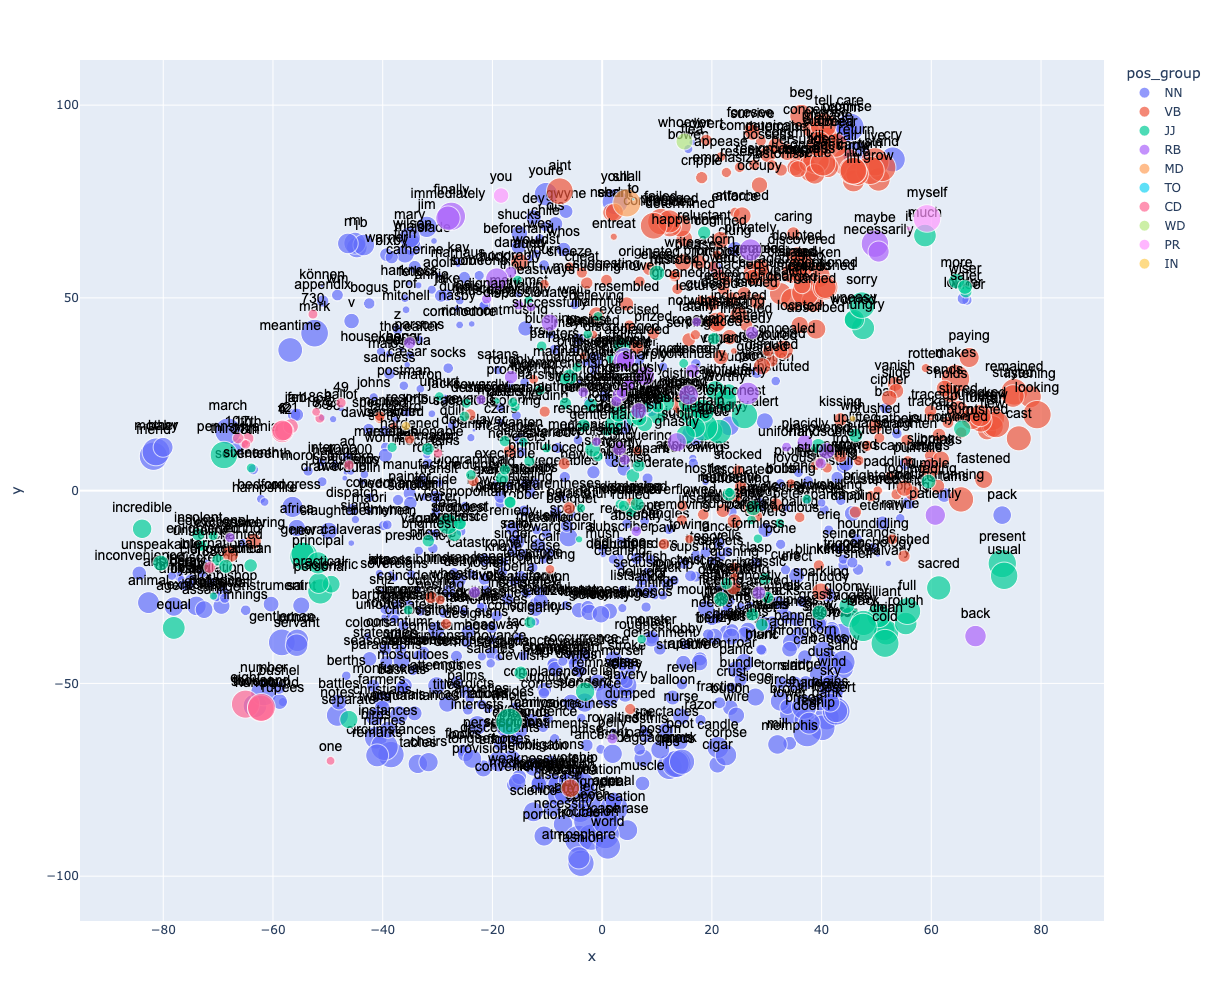

In [39]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

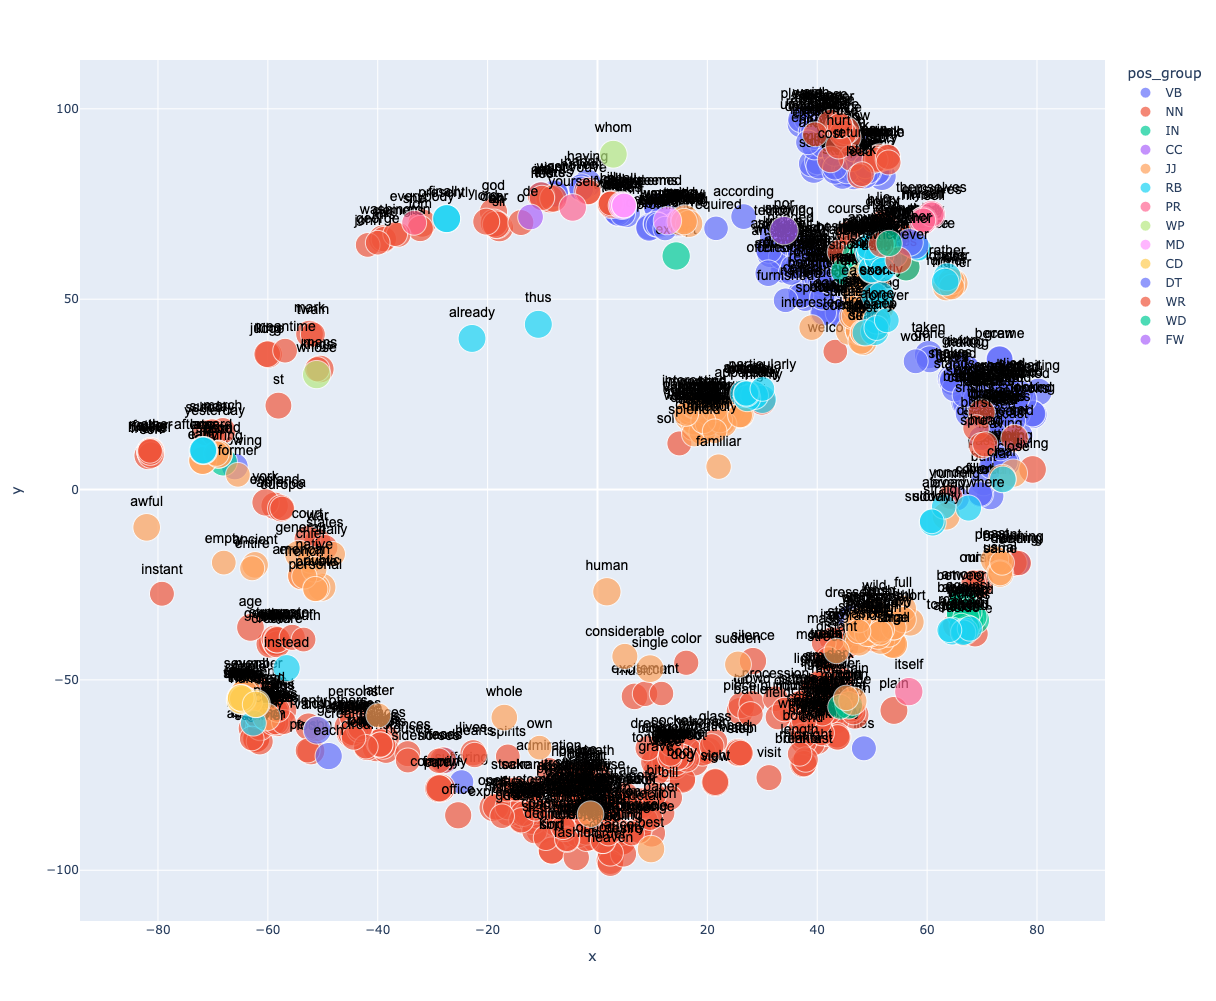

In [40]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

#### **With Nouns Only (not proper ones)**

In [41]:
noun_COORDS = COORDS.loc[COORDS.pos_group == 'NN']

noun_COORDS

x          y     n      dfidf pos_group     log_n
term_str                                                           
04       -49.950764  19.800415  10.0  18.227484        NN  2.302585
08       -50.145111  19.059072  10.0  10.113742        NN  2.302585
350      -53.410347   9.169445  24.0  67.918141        NN  3.178054
87       -49.367786  18.569710  13.0  38.959070        NN  2.564949
89       -51.060143  18.927137  15.0  38.959070        NN  2.708050
...             ...        ...   ...        ...       ...       ...
zermatt   34.265057 -67.250267  46.0  67.918141        NN  3.828641
zest     -12.579935   5.808639  12.0  67.918141        NN  2.484907
zu       -51.100506  52.666790  22.0  25.586339        NN  3.091042
à        -56.147686  51.326492  44.0  51.144711        NN  3.784190
était    -53.847881  50.613708  13.0  10.113742        NN  2.564949

[7916 rows x 6 columns]

#### **Noun tSNE plot**

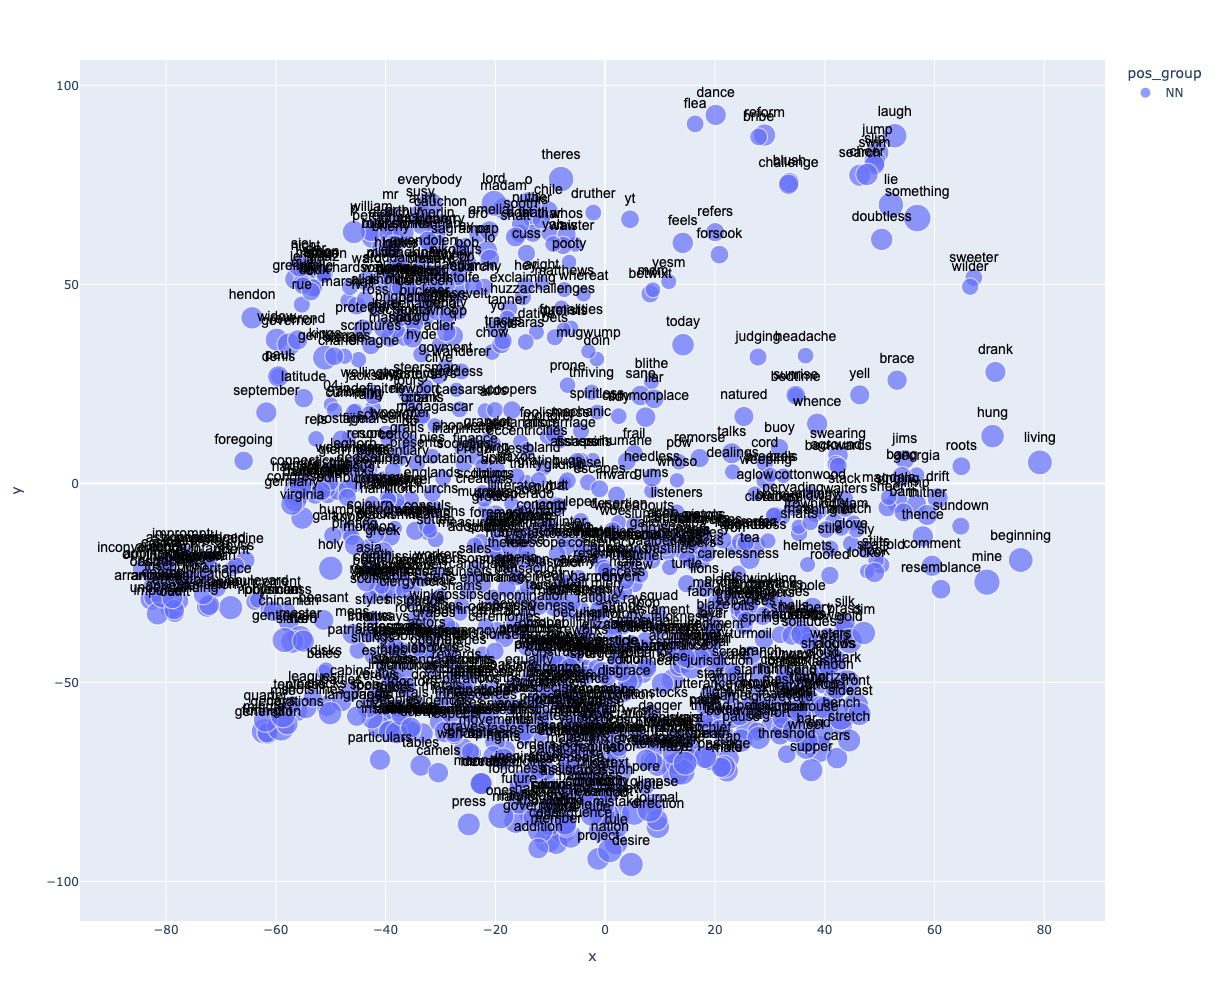

In [67]:
px.scatter(noun_COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',
           size = 'log_n',
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

#### **Clusters in Nouns Plot**
* Morning, summer, hour, seconds, times, ages $\rightarrow$ time (of day, year)
* Care, excuse, play, blow, cheer $\rightarrow$ carefree, mischievious, antics
* Honesty, ability, affection, powers, protection, worship $\rightarrow$ reverence, ability
* Accord, stupidity, piety, criticisms, devotions, genuineness, prosperity $\rightarrow$ conflicting views on religion, agreement
* Plunder, ordeal, crusades, conflagrations, pilgrimage, caution, tranquility $\rightarrow$ conflicting faces of religious activities throughout history

### **Analogies and Similarities (vector algebra)**

In [43]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [44]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0  child  0.776828
1   girl  0.767200
2   lady  0.722114

In [45]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0  brother  0.823369
1   sister  0.801899
2  darling  0.779816

In [46]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0  darling  0.804392
1  brother  0.759961
2    liege  0.728171

In [47]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0     lady  0.878961
1     girl  0.817366
2   fellow  0.735923
3  soldier  0.704647
4   farmer  0.695843

In [48]:
complete_analogy('woman', 'lady', 'man', 5)

term       sim
0  gentleman  0.824686
1     master  0.699578
2    citizen  0.692256
3     person  0.685369
4   stranger  0.683805

In [49]:
complete_analogy('day', 'sun', 'night', 5)

term       sim
0      rain  0.783103
1      wind  0.757743
2  darkness  0.744765
3     storm  0.722417
4   curtain  0.719862

In [68]:
complete_analogy('king', 'rich', 'servant', 5)

term       sim
0   slender  0.711932
1  graceful  0.702313
2  handsome  0.695950
3  splendid  0.687642
4       fat  0.687409

In [69]:
complete_analogy('lord', 'rich', 'servant', 5)

term       sim
0  handsome  0.720002
1  graceful  0.715430
2   slender  0.702366
3    coarse  0.686488
4      dumb  0.669372

In [70]:
complete_analogy('man', 'journey', 'woman', 5)

term       sim
0   voyage  0.706367
1     trip  0.658042
2  stretch  0.630050
3   spring  0.614480
4   flight  0.605543

In [71]:
complete_analogy('woman', 'marriage', 'man', 5)

term       sim
0  commission  0.753536
1    services  0.752548
2       birth  0.733643
3      powers  0.730161
4   departure  0.726789

In [72]:
complete_analogy('man', 'property', 'woman', 5)

term       sim
0   affairs  0.755897
1    rights  0.741495
2   society  0.733355
3    sorrow  0.725145
4  religion  0.721457

In [73]:
complete_analogy('man', 'fool', 'woman', 5)

term       sim
0   devil  0.696721
1   child  0.651625
2     lad  0.635922
3    girl  0.624696
4  beggar  0.623952

In [74]:
complete_analogy('woman', 'fool', 'man', 5)

term       sim
0    person  0.644702
1     hurry  0.603647
2       dog  0.591042
3  stranger  0.585422
4    chance  0.574519

In [75]:
complete_analogy('man', 'wise', 'woman', 5)

term       sim
0  innocent  0.697347
1   foolish  0.680637
2     brave  0.677902
3    simple  0.635330
4  ignorant  0.630998

In [76]:
complete_analogy('woman', 'wise', 'man', 5)

term       sim
0      worthy  0.670954
1  reasonable  0.644145
2      useful  0.641109
3     correct  0.634468
4      likely  0.620507

## Similarites

In [50]:
get_most_similar('joy')

term       sim
0       delight  0.801221
1    admiration  0.784409
2     gratitude  0.747991
3        sorrow  0.747686
4  astonishment  0.731498
5        fright  0.726452
6      blessing  0.722288
7        spirit  0.719269
8         glory  0.714442
9    excitement  0.705790

In [51]:
get_most_similar('man')

term       sim
0     person  0.850920
1  gentleman  0.794088
2      woman  0.766792
3   stranger  0.740261
4        dog  0.718034
5     fellow  0.690010
6       fool  0.664921
7    citizen  0.647081
8       girl  0.645880
9      slave  0.635982

In [52]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0       money  0.344735
1    business  0.268716
2   necessary  0.265689
3  government  0.258725
4      chance  0.255060
5    yourself  0.251223
6      public  0.250115
7       wrong  0.246364
8       going  0.243778
9     further  0.243301

In [53]:
get_most_similar(positive='woman')

term       sim
0       girl  0.866291
1  gentleman  0.831650
2       lady  0.820941
3     fellow  0.811571
4        man  0.766792
5    soldier  0.765872
6     person  0.760113
7   creature  0.756210
8      slave  0.755404
9      child  0.738329

In [54]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0       young  0.452947
1       sweet  0.428815
2  friendless  0.419484
3      sister  0.403715
4        gray  0.398251
5        jane  0.391606
6     colored  0.371316
7     husband  0.370074
8     peasant  0.368533
9         old  0.367854

In [55]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0         free  0.305291
1        human  0.292779
2      neither  0.269210
3          nor  0.239546
4    honorable  0.234591
5           an  0.230809
6         lack  0.229228
7   reasonable  0.228167
8        utter  0.226937
9  independent  0.226737

In [57]:
get_most_similar('knowledge')

term       sim
0     quality  0.846008
1      method  0.830475
2      genius  0.826863
3      system  0.826707
4   statement  0.825331
5   invention  0.824492
6  importance  0.820199
7    language  0.815986
8       crime  0.814865
9      wisdom  0.811844

In [58]:
get_most_similar('rich')

term       sim
0     handsome  0.765206
1     graceful  0.745025
2         pure  0.732829
3     charming  0.727296
4         nice  0.724187
5  picturesque  0.721800
6         neat  0.716759
7       comely  0.710631
8         fine  0.710626
9    beautiful  0.706341

In [59]:
get_most_similar('poor')

term       sim
0       brave  0.669315
1       young  0.642734
2  friendless  0.611581
3       devil  0.585920
4        sick  0.568551
5        weak  0.567297
6      gentle  0.563504
7       child  0.557940
8        girl  0.547192
9    innocent  0.546639

In [77]:
get_most_similar('money')

term       sim
0  trouble  0.772665
1     food  0.682620
2    stock  0.677449
3   orders  0.652256
4    delay  0.649710
5      use  0.641453
6   chance  0.635294
7    wages  0.626738
8   profit  0.626591
9  purpose  0.626240

#### **Sources**

* Dropping multiple columns by name starting with `drop` and `loc`: https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/
* Adding a new index level from the columns of a dataframe: https://stackoverflow.com/questions/14744068/prepend-a-level-to-a-pandas-multiindex

In [86]:
# tm.THETA.to_csv('twain_THETA.csv')
# tm.PHI.to_csv('twain_PHI.csv')
# tm.TOPIC.to_csv('twain_TOPIC.csv')
pd.DataFrame(SENTS).to_csv('twain_SENTS.csv')
# W2V.to_csv('twain_W2V.csv')
# COORDS.to_csv('twain_COORDS.csv')